In [10]:
import torch
import datetime

from torch.nn.functional import tanh
from dataset import get_data_transforms
from torchvision.datasets import ImageFolder
from collections import OrderedDict
from torchvision import transforms
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import os
from dice_score import dice_loss
from torch.utils.data import DataLoader
from resnet import resnet18, resnet34, resnet50, wide_resnet50_2
from de_resnet import de_resnet18, de_resnet34, de_wide_resnet50_2, de_resnet50
from dataset import MVTecDataset
import torch.backends.cudnn as cudnn
import argparse
from unet_model import UNet
from test_dest import evaluation, visualization, test
from torch.nn import functional as F
from dataset_cp import MVTecAT, Repeat
from network_denoising import Dn0, Dn1, Dn2, Dn3
from cutpaste import CutPasteNormal,CutPasteScar, CutPaste3Way, CutPasteUnion, cut_paste_collate_fn

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def loss_function(a, b):
    #mse_loss = torch.nn.MSELoss()
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    for item in range(len(a)):
        #print(a[item].shape)
        #print(b[item].shape)
        #loss += 0.1*mse_loss(a[item], b[item])
        loss += torch.mean(1-cos_loss(a[item].view(a[item].shape[0],-1),
                                      b[item].view(b[item].shape[0],-1)))
    return loss

def loss_concat(a, b):
    mse_loss = torch.nn.MSELoss()
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    a_map = []
    b_map = []
    size = a[0].shape[-1]
    for item in range(len(a)):
        #loss += mse_loss(a[item], b[item])
        a_map.append(F.interpolate(a[item], size=size, mode='bilinear', align_corners=True))
        b_map.append(F.interpolate(b[item], size=size, mode='bilinear', align_corners=True))
    a_map = torch.cat(a_map,1)
    b_map = torch.cat(b_map,1)
    loss += torch.mean(1-cos_loss(a_map,b_map))
    return loss

def addnoise(img,SNR):
  img_var = torch.std(img)**2
  noise_var = img_var / (10**(SNR/10))
  noise = torch.sqrt(noise_var)*(torch.randn(img.shape)).cuda()
  #print("noise=", noise)
  return img+noise

def get_mask(normal,anomaly): #inputs are normal and artificial anomalous images (as batch)
    
    diff = (normal-anomaly).bool()

    return torch.logical_or(torch.logical_or(diff[:,0,:,:],diff[:,1,:,:]),diff[:,2,:,:]).int()
    
def addnoise_batch(img,snr_range=(-5,35)):
  batch_size = img.shape[0]
  snr = np.random.uniform(low=snr_range[0],high=snr_range[1],size=batch_size)
  noisy_img = np.array([addnoise(img[i],snr[i]).cpu().numpy() for i in range(batch_size)])
  return torch.Tensor(noisy_img)

bottle
cuda


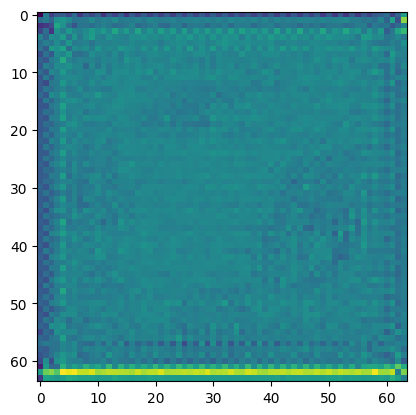

In [13]:
def vis(_class_):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    print(_class_)
    epochs = 200
    learning_rate = 0.005
    batch_size = 8
    image_size = 256
    min_scale = 1
    workers = 2
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.
    data_type = _class_
    print(device)

    data_transform, gt_transform = get_data_transforms(image_size, image_size)
    
    # train_path = '/content/drive/MyDrive/mvtec/' + _class_ 
    # test_path = '/content/drive/MyDrive/mvtec/' + _class_
    #ckp_path = '/home/ai22mtech11001/Siva/RD_Unified/checkpoints/models'
    model_name = f"model-{data_type}" + '-{date:%Y-%m-%d_%H_%M_%S}'.format(date=datetime.datetime.now() )
    model_dir = "models"
    # train_data = ImageFolder(root=train_path, transform=data_transform)
    
    # #print("train_data=", train_data)
    # #sys.exit()
    
    # test_data = MVTecDataset(root=test_path, transform=data_transform, gt_transform=gt_transform, phase="test")
    
    # train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

    #########################################

    after_cutpaste_transform = transforms.Compose([])
    after_cutpaste_transform.transforms.append(transforms.ToTensor())
    #after_cutpaste_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
     #                                                               std=[0.229, 0.224, #0.225]))

    train_transform = transforms.Compose([])
    #train_transform.transforms.append(transforms.RandomResizedCrop(size, scale=(min_scale,1)))
    train_transform.transforms.append(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
    # train_transform.transforms.append(transforms.GaussianBlur(int(size/10), sigma=(0.1,2.0)))
    train_transform.transforms.append(transforms.Resize((image_size,image_size)))
    train_transform.transforms.append(CutPaste3Way(transform = after_cutpaste_transform))
    #'
    #changed from cutpate_type(transform = after_cutpaste_transform)
    # train_transform.transforms.append(transforms.ToTensor())
    
    image_size1=int(image_size * (1/min_scale))

    #train_data = MVTecAT("/home/ai22mtech11001/Siva/other/mvtec", data_type, image_size1, transform = train_transform)
    
    
    # dataloader = DataLoader(Repeat(train_data, 300), batch_size=batch_size, drop_last=True,
    #                         shuffle=True, num_workers=workers, collate_fn=cut_paste_collate_fn,
    #                         persistent_workers=True, pin_memory=True, prefetch_factor=5)
    
    #Validation
    test_path = '/home/ai22mtech11001/Siva/other/mvtec/' + _class_
    test_data = MVTecDataset(root=test_path, transform=data_transform,
    gt_transform=gt_transform, phase="test")
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
    
    
    # num_batches = len(dataloader)
    # def get_data_inf():
    #     while True:
    #         for out in enumerate(dataloader):
    #             yield out
    # dataloader_inf =  get_data_inf()

    ##################################

    encoder, bn = resnet18(pretrained=False)
    #encoder = encoder.to(device)
    #print("encoder=", encoder)
    #sys.exit()
    
    modelname = '/home/ai22mtech11001/Siva/other/models_cp/model-2023-03-28_15_46_54.tch'
    model_rd = "/home/ai22mtech11001/Siva/other/checkpoints/model.pth"
    weights_rd = torch.load(model_rd)
    
    weights = torch.load(modelname)
    
    weights_keys = list(weights.keys())
    rem_list = ["resnet18.layer1.0.bn1.num_batches_tracked",\
            "resnet18.layer1.0.bn2.num_batches_tracked",\
            "resnet18.layer1.1.bn1.num_batches_tracked",\
            "resnet18.layer1.1.bn2.num_batches_tracked",\
            "resnet18.layer2.0.bn1.num_batches_tracked",\
            "resnet18.layer2.0.bn2.num_batches_tracked",\
            "resnet18.layer2.1.bn1.num_batches_tracked",\
            "resnet18.layer2.1.bn2.num_batches_tracked",\
            "resnet18.layer3.0.bn1.num_batches_tracked",\
            "resnet18.layer3.0.bn2.num_batches_tracked",\
            "resnet18.layer3.1.bn1.num_batches_tracked",\
            "resnet18.layer3.1.bn2.num_batches_tracked",\
            "resnet18.layer4.0.bn1.num_batches_tracked",\
            "resnet18.layer4.0.bn2.num_batches_tracked",\
            "resnet18.layer4.1.bn1.num_batches_tracked",\
            "resnet18.layer4.1.bn2.num_batches_tracked",\
            "resnet18.bn1.num_batches_tracked",\
            "resnet18.layer2.0.downsample.1.num_batches_tracked",\
            "resnet18.layer3.0.downsample.1.num_batches_tracked",\
            "resnet18.layer4.0.downsample.1.num_batches_tracked",\
            "head.0.weight","head.0.bias", "head.1.weight", "head.1.bias", "head.1.running_mean", "head.1.running_var", "head.1.num_batches_tracked", "head.3.weight", "head.3.bias", "head.4.weight", "head.4.bias", "head.4.running_mean", "head.4.running_var", "head.4.num_batches_tracked", "out.weight", "out.bias", "head.6.weight", "head.6.bias", "head.7.weight", "head.7.bias", "head.7.running_mean", "head.7.running_var", "head.7.num_batches_tracked"]
			
            
    [weights.pop(key) for key in rem_list]
    
    new_keys = ["conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var"]
    
    #print("new2", len(new2))
                  
    weights2 = OrderedDict([('a',1)])
    i=0
    #print("new_keys=", len(weights2))
    for key in weights.keys():
        temp = weights[key]
        weights2[new_keys[i]] = temp
        i = i + 1
    
    weights2.pop('a')
    encoder.load_state_dict(weights2)
     #with this encoder is replaced with cutpaste model
    #similarly load bn,decoder weights from RD model
    #bn = bn.to(device)
    encoder.eval()
    decoder = de_resnet18(pretrained=False)
    #decoder = decoder.to(device)
    bn.load_state_dict(weights_rd["bn"])
    decoder.load_state_dict(weights_rd["decoder"])
    bn.eval()
    decoder.eval()

    transform_norm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    criterion = torch.nn.BCEWithLogitsLoss()
    loss_list = []
    up = torch.nn.Upsample(size=(64,64), mode='bilinear')
    up2 = torch.nn.Upsample(size=(256,256), mode='bilinear')
    cos_sim = torch.nn.CosineSimilarity(dim=1)
    seg = UNet(n_channels=3,n_classes=1)
    #seg.train()
    #seg = torch.nn.DataParallel(seg, device_ids=[0, 1, 2])  
    seg = seg.to(device)
    seg_weights = torch.load("/home/ai22mtech11001/Siva/other/models/model-bottle-2023-06-06_12_31_53.tch")
    seg.load_state_dict(seg_weights["seg"])
    #seg.train()  
    seg.eval()
    for i in range(1,2):
       
        epoch_loss = 0
        for img, gt, label, _ in test_dataloader:
            
            #inputs = torch.concat((normal,cp,cps),dim=0)#.to(device)
            t_out = encoder(transform_norm(img))
            s_out = decoder(bn(t_out))
            #s_out = [s_out[0].to(device),s_out[1].to(device),s_out[2].to(device)]
            #print(t_out[0].shape,t_out[1].shape,t_out[2].shape) #N*64*64*64,N*128*32*32,N*256*16*16
            #print(s_out[0].shape,s_out[1].shape,s_out[2].shape)
            #print(cos_sim(t_out[1],s_out[1]).shape) #N*32*32
            X1 = up(cos_sim(t_out[0],s_out[0]).unsqueeze(dim=1))
            X2 = up(cos_sim(t_out[1],s_out[1]).unsqueeze(dim=1))
            X3 = up(cos_sim(t_out[2],s_out[2]).unsqueeze(dim=1))
            X = torch.concat((X1,X2,X3),dim=1).to(device)
            #print(X.shape) #N*3*64,64
            mask = seg(X)
            plt.imshow(mask.squeeze().detach().cpu().numpy())
            # true_masks = get_mask(inputs.to(device),torch.concat((normal,normal,normal),dim=0).to(device))
            
            # mask = up2(mask) 
            # loss = criterion(mask.squeeze(),true_masks.float().to(device))
            # loss += dice_loss(torch.nn.functional.sigmoid(mask.squeeze()), true_masks.float().to(device), multiclass=False)


            # epoch_loss += loss 
            #loss= 0.1
            #loss_list.append(epoch_loss.item())

            #loss_list.append(loss.item())
            #print("batch =",batch_idx)
       # print('epoch [{}/{}], loss:{:.4f}'.format(i, epochs, epoch_loss))
        # if (i + 1) % 1 == 0:
        #     #auroc_px, auroc_sp, aupro_px = evaluation(encoder, bn, decoder, seg, test_dataloader, device)
        #     #print('Pixel Auroc:{:.3f}, Sample Auroc{:.3f}, Pixel Aupro{:.3}'.format(auroc_px, auroc_sp, aupro_px))
        #     torch.save({'seg': seg.state_dict(),
        #                 }, model_dir + f"/{model_name}.tch")
    #return auroc_px, auroc_sp, aupro_px

if __name__ == '__main__':

    setup_seed(111)
    item_list = ['bottle']
    for i in item_list:
        vis(i)
